# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

## Load custom functions from file:
source("Functions.R")

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
# theme_set(theme_bw(base_size = 16))
## ... or set the default theme
theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [2]:
# system('./Misc/initial_file_modifications.sh')

Load the modENCODE expression atlas:

In [3]:
mel_modENCODE = read.csv("Annotoations/gene_rpkm_report_fb_2018_02.tsv", header = T, sep = "\t")

Load read count data:

In [4]:
counts_bt2 = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

Load annotation files:

In [5]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [6]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the transcript lengths for the eXpress data:

In [7]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [8]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [9]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

Generate sample info object:

In [10]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [11]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 20000000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [12]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

the `geneBoxPlot` function can be used for single gene tpm plots of the data:

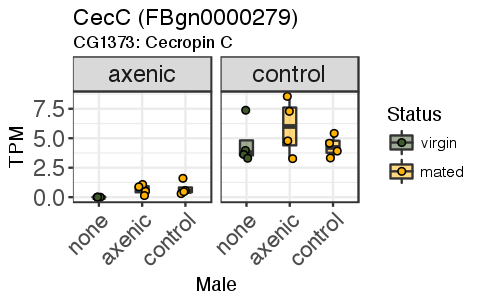

In [135]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
geneBoxPlot("CecC", show_reps = F)

Output library size object:

In [14]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)

Make a barplot of library sizes:

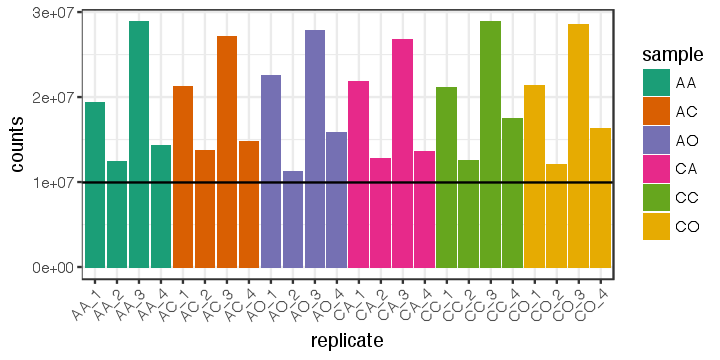

In [15]:
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

### Differential expression analysis (eXpress):

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [65]:
# counts_bt2 = subset(counts_bt2, rownames(counts_bt2) %!in% wierd_genes)
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep_bt2 <- counts_bt2[keep_bt2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
dim(countsKeep_bt2)

[1] 7649   24

Now define the groupings by sample and set up the design matrix:

In [66]:
groups = factor(sampleInfo$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Create the DGElist object and GLM fit:

In [67]:
dgeList <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList <- calcNormFactors(dgeList)
dgeList <- estimateCommonDisp(dgeList)
dgeList <- estimateTagwiseDisp(dgeList)
dgeList_fit <- glmFit(dgeList, design)
summary(dgeList$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02658 0.05811 0.07449 0.13260 0.12080 3.49400 

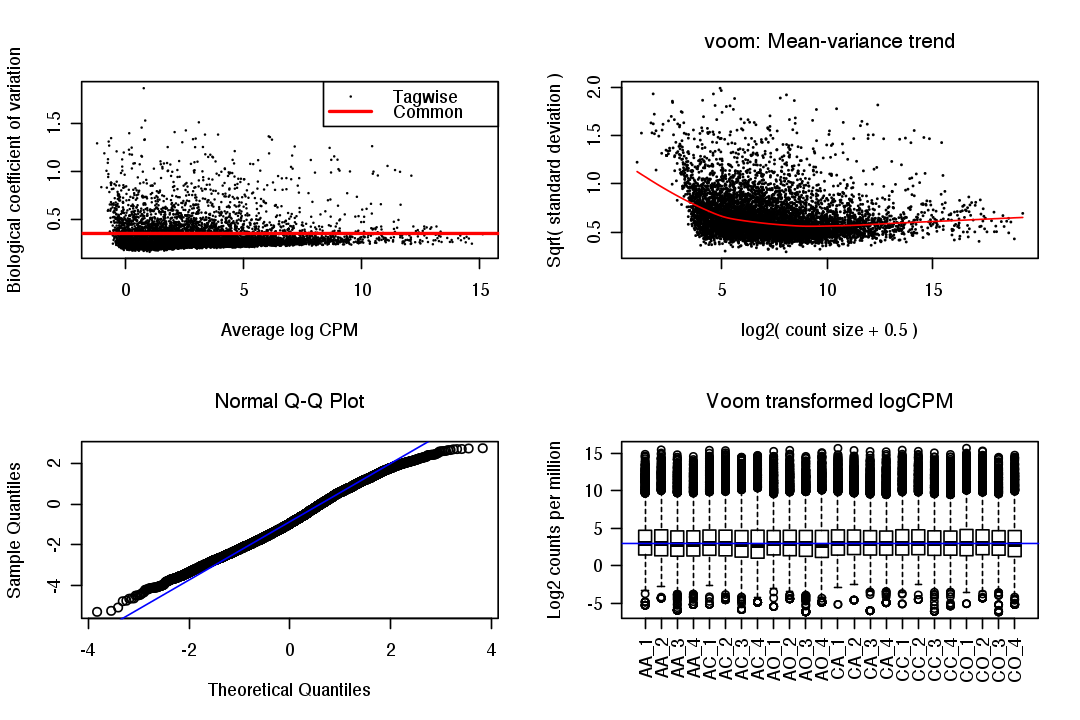

In [69]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
virgin.voom = voom(dgeList, design, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Generate a correlation plot between replicates:

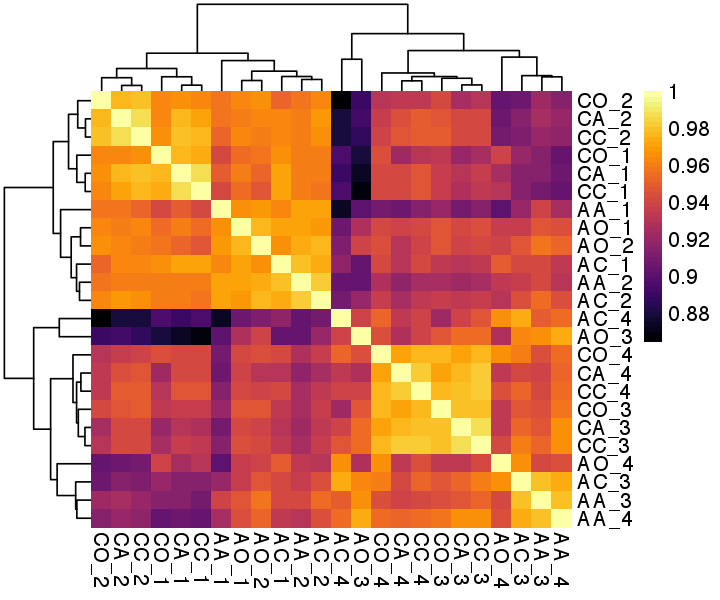

In [70]:
## Plot sample correlation
data = log2(countsKeep_bt2+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 6, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

In [71]:
mdsObj <- plotMDS(dgeList, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo, by.x = "replicate", by.y = "Replicate")
mdsObj$replicate_num = gsub(".*_", "", mdsObj$replicate)

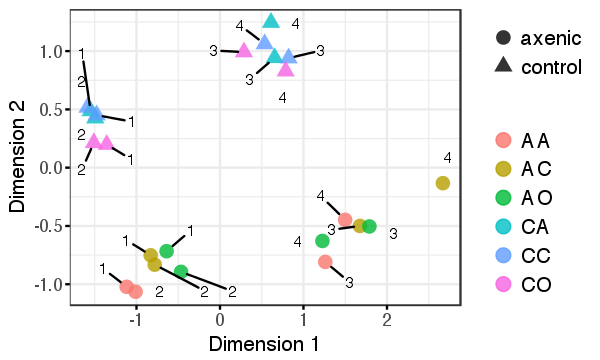

In [72]:
options(repr.plot.width = 5, repr.plot.height = 3)

# pdf("MDS.plot.pdf", width = 5, height = 3)
ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Sample",
              shape = "Female",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
#               star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
                geom_text_repel(aes(label=replicate_num), 
                    force = 10, 
#                     inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
#                 scale_colour_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
#                 scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                labs ( x = "Dimension 1", y = "Dimension 2")
# dev.off()

Something funny is going on with replicate grouping. First we'll explore the results without doing anything about the replicates. 

Before running the likelihood ration tests, we'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [73]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

First look at the difference between the axenic and control virgin samples:

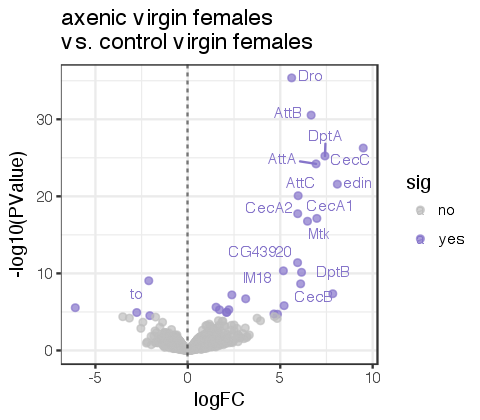

In [106]:
# define contrasts:
vrigin_contrasts <- makeContrasts(CO-AO, levels=design)

# run the LRT and extract the DE table
lrt.virgins <- glmLRT(dgeList_fit, contrast = vrigin_contrasts)
lrt.virgins.tTags <- topTags(lrt.virgins, n = NULL)
lrt.virgins.table <- lrt.virgins.tTags$table
lrt.virgins.table$sig = ifelse(lrt.virgins.table$FDR < 0.01 & (lrt.virgins.table$logFC > 1 | lrt.virgins.table$logFC < -1), "yes", "no")
lrt.virgins.table$direction = ifelse(lrt.virgins.table$sig == "yes" & lrt.virgins.table$logFC > 1, "Up", ifelse(lrt.virgins.table$sig == "yes" & lrt.virgins.table$logFC < -1, "Down", "n.s."))
lrt.virgins.table$gene = rownames(lrt.virgins.table)
lrt.virgins.table = merge(lrt.virgins.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
virgins_sigGenes = subset(lrt.virgins.table, sig == "yes")$gene
# 
options(repr.plot.width = 4, repr.plot.height = 3.5)
(vrigin_contrasts_volcano.gg = ggplot(lrt.virgins.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.7) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.virgins.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(title = "axenic virgin females \nvs. control virgin females", size = 2) +
    scale_colour_manual(values = c("gray","#8675ca")) +
    theme_bw())

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [83]:
# define contrasts:
AA.v.AO_contrasts <- makeContrasts(AA-AO, levels=design)

# run the LRT and extract the DE table
lrt.AA.v.AO <- glmLRT(dgeList_fit, contrast = AA.v.AO_contrasts)
lrt.AA.v.AO.tTags <- topTags(lrt.AA.v.AO, n = NULL)
lrt.AA.v.AO.table <- lrt.AA.v.AO.tTags$table
lrt.AA.v.AO.table$sig = ifelse(lrt.AA.v.AO.table$FDR < 0.01 & (lrt.AA.v.AO.table$logFC > 1 | lrt.AA.v.AO.table$logFC < -1), "yes", "no")
lrt.AA.v.AO.table$direction = ifelse(lrt.AA.v.AO.table$sig == "yes" & lrt.AA.v.AO.table$logFC > 1, "Up", ifelse(lrt.AA.v.AO.table$sig == "yes" & lrt.AA.v.AO.table$logFC < -1, "Down", "n.s."))
lrt.AA.v.AO.table$gene = rownames(lrt.AA.v.AO.table)
lrt.AA.v.AO.table = merge(lrt.AA.v.AO.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
AA.v.AO_sigGenes = subset(lrt.AA.v.AO.table, sig == "yes")$gene
# 
# options(repr.plot.width = 5, repr.plot.height = 3.5)
AA.v.AO_contrasts_volcano.gg = ggplot(lrt.AA.v.AO.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.AA.v.AO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) +
    labs(title = "axenic females X axenic males\nvs. axenic virgin females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

... and females mated to control males

In [84]:
# define contrasts:
AC.v.AO_contrasts <- makeContrasts(AC-AO, levels=design)

# run the LRT and extract the DE table
lrt.AC.v.AO <- glmLRT(dgeList_fit, contrast = AC.v.AO_contrasts)
lrt.AC.v.AO.tTags <- topTags(lrt.AC.v.AO, n = NULL)
lrt.AC.v.AO.table <- lrt.AC.v.AO.tTags$table
lrt.AC.v.AO.table$sig = ifelse(lrt.AC.v.AO.table$FDR < 0.01 & (lrt.AC.v.AO.table$logFC > 1 | lrt.AC.v.AO.table$logFC < -1), "yes", "no")
lrt.AC.v.AO.table$direction = ifelse(lrt.AC.v.AO.table$sig == "yes" & lrt.AC.v.AO.table$logFC > 1, "Up", ifelse(lrt.AC.v.AO.table$sig == "yes" & lrt.AC.v.AO.table$logFC < -1, "Down", "n.s."))
lrt.AC.v.AO.table$gene = rownames(lrt.AC.v.AO.table)
lrt.AC.v.AO.table = merge(lrt.AC.v.AO.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
AC.v.AO_sigGenes = subset(lrt.AC.v.AO.table, sig == "yes")$gene
# 
# options(repr.plot.width = 5, repr.plot.height = 3.5)
AC.v.AO_contrasts_volcano.gg = ggplot(lrt.AC.v.AO.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.AC.v.AO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) +
    labs(title = "axenic females X control males\nvs. axenic virgin females", size = 2) +
    scale_colour_manual(values = c("gray","#007954")) +
    theme_bw()

Show those volcano plots:

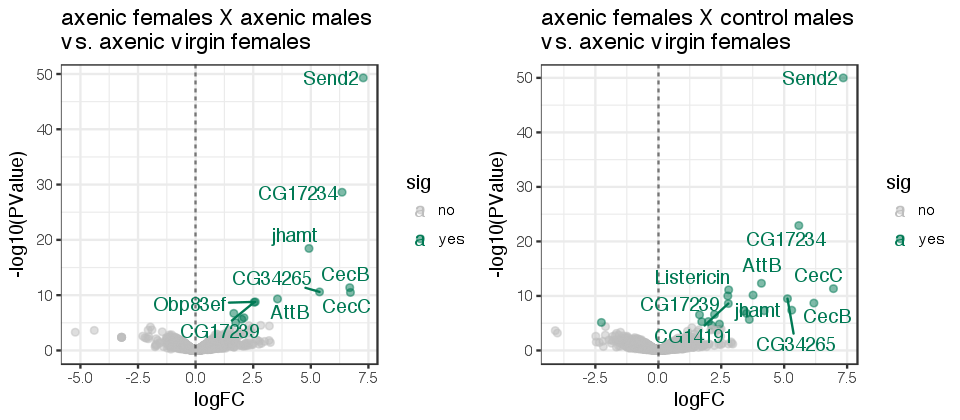

In [82]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
plot_grid(AA.v.AO_contrasts_volcano.gg, AC.v.AO_contrasts_volcano.gg, ncol = 2)

Now let's look at the control females.

First, females mated to axenic males

In [90]:
# define contrasts:
CA.v.CO_contrasts <- makeContrasts(CA-CO, levels=design)

# run the LRT and extract the DE table
lrt.CA.v.CO <- glmLRT(dgeList_fit, contrast = CA.v.CO_contrasts)
lrt.CA.v.CO.tTags <- topTags(lrt.CA.v.CO, n = NULL)
lrt.CA.v.CO.table <- lrt.CA.v.CO.tTags$table
lrt.CA.v.CO.table$sig = ifelse(lrt.CA.v.CO.table$FDR < 0.01 & (lrt.CA.v.CO.table$logFC > 1 | lrt.CA.v.CO.table$logFC < -1), "yes", "no")
lrt.CA.v.CO.table$direction = ifelse(lrt.CA.v.CO.table$sig == "yes" & lrt.CA.v.CO.table$logFC > 1, "Up", ifelse(lrt.CA.v.CO.table$sig == "yes" & lrt.CA.v.CO.table$logFC < -1, "Down", "n.s."))
lrt.CA.v.CO.table$gene = rownames(lrt.CA.v.CO.table)
lrt.CA.v.CO.table = merge(lrt.CA.v.CO.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
CA.v.CO_sigGenes = subset(lrt.CA.v.CO.table, sig == "yes")$gene
# 
# options(repr.plot.width = 5, repr.plot.height = 3.5)
CA.v.CO_contrasts_volcano.gg = ggplot(lrt.CA.v.CO.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.CA.v.CO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) +
    labs(title = "control females X axenic males\nvs. control virgin females", size = 2) +
    scale_colour_manual(values = c("gray","#c9578c")) +
    theme_bw()

... and females mated to control males

In [95]:
# define contrasts:
CC.v.CO_contrasts <- makeContrasts(CC-CO, levels=design)

# run the LRT and extract the DE table
lrt.CC.v.CO <- glmLRT(dgeList_fit, contrast = CC.v.CO_contrasts)
lrt.CC.v.CO.tTags <- topTags(lrt.CC.v.CO, n = NULL)
lrt.CC.v.CO.table <- lrt.CC.v.CO.tTags$table
lrt.CC.v.CO.table$sig = ifelse(lrt.CC.v.CO.table$FDR < 0.01 & (lrt.CC.v.CO.table$logFC > 1 | lrt.CC.v.CO.table$logFC < -1), "yes", "no")
lrt.CC.v.CO.table$direction = ifelse(lrt.CC.v.CO.table$sig == "yes" & lrt.CC.v.CO.table$logFC > 1, "Up", ifelse(lrt.CC.v.CO.table$sig == "yes" & lrt.CC.v.CO.table$logFC < -1, "Down", "n.s."))
lrt.CC.v.CO.table$gene = rownames(lrt.CC.v.CO.table)
lrt.CC.v.CO.table = merge(lrt.CC.v.CO.table, FBgn_to_symbol, by.x = "gene", by.y = "primary_FBgn", all.x = T)
CC.v.CO_sigGenes = subset(lrt.CC.v.CO.table, sig == "yes")$gene
# 
# options(repr.plot.width = 5, repr.plot.height = 3.5)
CC.v.CO_contrasts_volcano.gg = ggplot(lrt.CC.v.CO.table, aes(logFC, -log10(PValue), colour = sig)) +
    geom_point(alpha = 0.5) +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) +
    geom_text_repel(data = filter(lrt.CC.v.CO.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                    force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) +
    labs(title = "control females X control males\nvs. control virgin females", size = 2) +
    scale_colour_manual(values = c("gray","#c9578c")) +
    theme_bw()

Show those volcano plots:

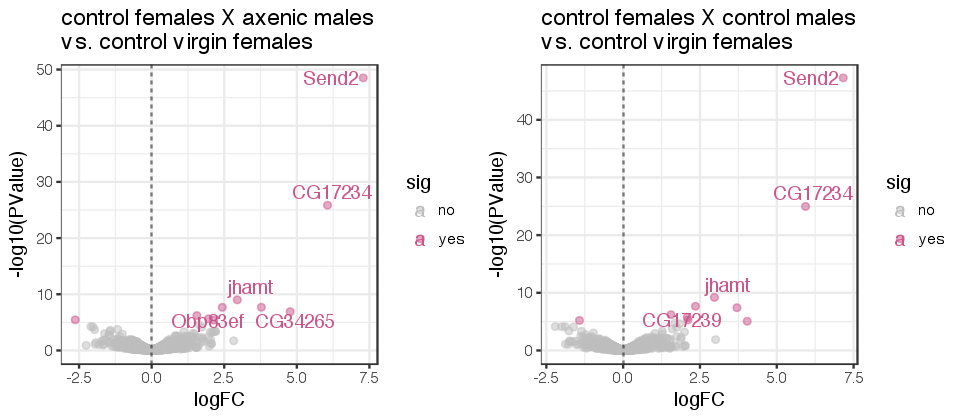

In [96]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
plot_grid(CA.v.CO_contrasts_volcano.gg, CC.v.CO_contrasts_volcano.gg, ncol = 2)

Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

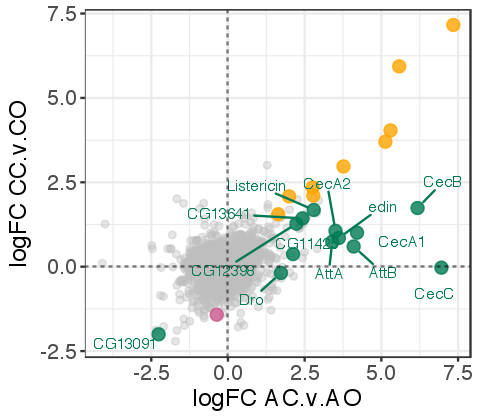

In [152]:
tmpDF = merge(lrt.AC.v.AO.table, lrt.CC.v.CO.table, by.x = "gene", by.y = "gene", all.x = T)

options(repr.plot.width = 4, repr.plot.height = 3.5)
ggplot() + 
    geom_point(data = subset(tmpDF, sig.x == "no" & sig.y == "no"),
               aes(logFC.x, logFC.y), 
               colour = "gray",
               alpha = 0.4) +
    geom_point(data = subset(tmpDF, sig.x == "yes" & sig.y == "no"),
               aes(logFC.x, logFC.y), 
               colour = "#007954",
               alpha = 0.8,
               size = 3) +
    geom_point(data = subset(tmpDF, sig.x == "no" & sig.y == "yes"),
               aes(logFC.x, logFC.y), 
               colour = "#c9578c",
               alpha = 0.8,
               size = 3) +
    geom_point(data = subset(tmpDF, sig.x == "yes" & sig.y == "yes"),
               aes(logFC.x, logFC.y), 
               colour = "orange",
               alpha = 0.8,
               size = 3) +
    geom_text_repel(data = subset(tmpDF, sig.x == "yes" & sig.y == "no"),aes(logFC.x, logFC.y, label=gene_symbol.y),
                    force = 10, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3,
                    colour = "#007954") +
#     geom_text_repel(data = subset(tmpDF, sig.x == "yes" & sig.y == "yes"),aes(logFC.x, logFC.y, label=gene_symbol.y),
#                     force = 10, 
#                     inherit.aes = F, 
#                     box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
#                     fontface = "bold", 
#                     size = 4,
#                     colour = "orange") +
    geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
    geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
    theme_bw() +
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 14)) +
    labs(x = "logFC AC.v.AO", y = "logFC CC.v.CO")

rm(tmpDF)

In [226]:
mel_modENCODE_subset = subset(mel_modENCODE, select = c("FBgn_ID", "RNASource_name", "RPKM_value"))
mel_modENCODE_matrix = cast(mel_modENCODE_subset, FBgn_ID~RNASource_name, value = "RPKM_value")
mel_modENCODE_matrix2 <- mel_modENCODE_matrix[,-1]
rownames(mel_modENCODE_matrix2) <- mel_modENCODE_matrix[,1]

In [227]:
wierdMatrix = subset(mel_modENCODE_matrix2, rownames(mel_modENCODE_matrix2) %in% wierd_genes)

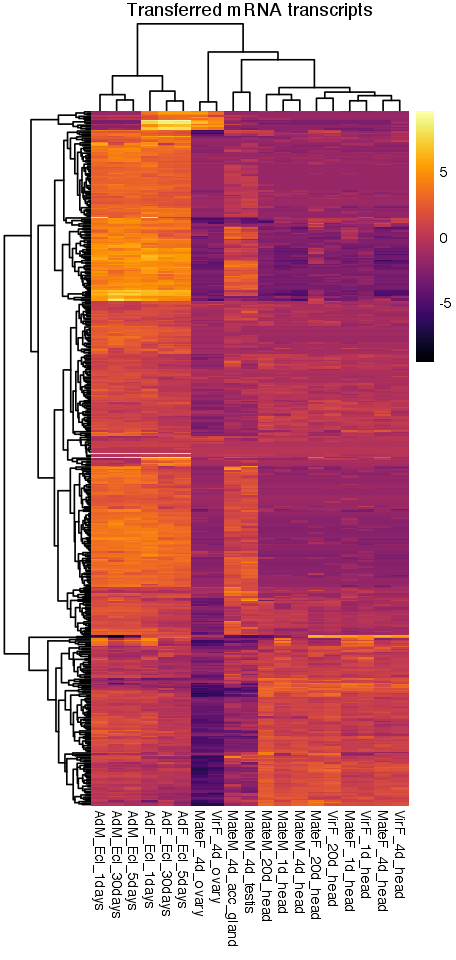

In [229]:
data = log2(wierdMatrix+1)
data = t(scale(t(data), scale=F))
# data[data < -3] = -3
# data[data > 3] = 3

options(repr.plot.width = 3.8, repr.plot.height = 8)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
#   annotation_row    = annotationType,
#   annotation_colors = mat_colors,
  drop_levels       = TRUE,
#   cluster_col    = FALSE,
  annotation_names_row = F,
  main              = "Transferred mRNA transcripts",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 3.8, 
#   height            = 5,
  fontsize          = 8    
)